In [93]:
import tensorflow as tf 
from tensorflow.keras import models,layers
import numpy as np
import matplotlib.pyplot as plt
# tf.config.set_visible_devices([],'GPU')

In [104]:
import tensorflow as tf

# Check if GPU is available using the recommended function
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available.")
    # Your GPU-accelerated code here
else:
    print("GPU is not available. Check your TensorFlow installation.")

GPU is available.


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Memory growth set for GPU: {gpu}")
    except RuntimeError as e:
        print(e)

Memory growth set for GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
IMG_SIZE = 224
BATCH_SIZE =32
EPOCHS=10

In [61]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('indianbird_train/',
                                                              shuffle=True,
                                                              image_size = (IMG_SIZE,IMG_SIZE),
                                                              batch_size = 32)

Found 30000 files belonging to 25 classes.


In [6]:
class_name = train_ds.class_names

In [7]:
train_ds = train_ds.take(400)

In [54]:
test_ds,val_ds = tf.keras.preprocessing.image_dataset_from_directory('indianbird_val/',
                                                              shuffle=True,
                                                              image_size = (IMG_SIZE,IMG_SIZE),
                                                              batch_size = 32,
                                                              seed=42,
                                                              subset='both',
                                                              validation_split=0.50)

Found 7500 files belonging to 25 classes.
Using 3750 files for training.
Using 3750 files for validation.


In [42]:
data_directory = r"C:\Users\thesu\anaconda3\envs\indianbird_train"
class_len = []

for name in class_name:
    class_length = len(list(tf.data.Dataset.list_files(data_directory + '/' + name + '/*')))
    print(f"Class {name}: {class_length} samples")
    class_len.append(class_length)

Class Asian-Green-Bee-Eater: 1200 samples
Class Brown-Headed-Barbet: 1200 samples
Class Cattle-Egret: 1200 samples
Class Common-Kingfisher: 1200 samples
Class Common-Myna: 1200 samples
Class Common-Rosefinch: 1200 samples
Class Common-Tailorbird: 1200 samples
Class Coppersmith-Barbet: 1200 samples
Class Forest-Wagtail: 1200 samples
Class Gray-Wagtail: 1200 samples
Class Hoopoe: 1200 samples
Class House-Crow: 1200 samples
Class Indian-Grey-Hornbill: 1200 samples
Class Indian-Peacock: 1200 samples
Class Indian-Pitta: 1200 samples
Class Indian-Roller: 1200 samples
Class Jungle-Babbler: 1200 samples
Class Northern-Lapwing: 1200 samples
Class Red-Wattled-Lapwing: 1200 samples
Class Ruddy-Shelduck: 1200 samples
Class Rufous-Treepie: 1200 samples
Class Sarus-Crane: 1200 samples
Class White-Breasted-Kingfisher: 1200 samples
Class White-Breasted-Waterhen: 1200 samples
Class White-Wagtail: 1200 samples


In [9]:
len(test_ds),len(val_ds)

(118, 118)

In [52]:
test_ds = test_ds.take(70)

In [56]:
val_ds = val_ds.take(40)

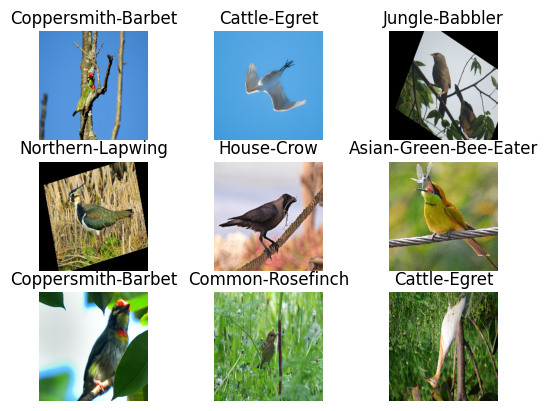

In [11]:
for image,label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.title(class_name[label[i]])
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.axis('off')

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
rescale_resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
pre_trained_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='max',
    classes=25,
    classifier_activation="softmax",
)

In [15]:
for layers in pre_trained_model.layers:
    layers.trainable=False

In [65]:
# Define a function to apply data augmentation to an image
def augment_image(image, label):
    # Randomly adjust the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Randomly rotate the image
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return image, label

# Assuming x_train and y_train are already created as tf.data.Dataset batches
# Apply data augmentation to the training data
augmented_train_ds = train_ds.map(augment_image)

In [66]:
CHANNELS = 3
INPUT_SHAPE = (BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)


model = models.Sequential([
    rescale_resize,
    pre_trained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(200,activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(25,activation="softmax")
])

model.build(input_shape=INPUT_SHAPE)

In [67]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_5 (Flatten)         (32, 1280)                0         
                                                                 
 batch_normalization_2 (Batc  (32, 1280)               5120      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (32, 200)                 256200    
                                                                 
 dropout_1 (Dropout)         (32, 200)                

In [68]:
import keras

model.compile(optimizer ='adam', 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['acc'])

In [71]:
%%time
histroy = model.fit(augmented_train_ds,validation_data=val_ds,epochs=100)

Epoch 1/100
938/938 [==============================] - 125s 132ms/step - loss: 0.5477 - acc: 0.8412 - val_loss: 0.3421 - val_acc: 0.8914
Epoch 2/100
938/938 [==============================] - 125s 133ms/step - loss: 0.4034 - acc: 0.8750 - val_loss: 0.3186 - val_acc: 0.9086
Epoch 3/100
938/938 [==============================] - 125s 133ms/step - loss: 0.3439 - acc: 0.8902 - val_loss: 0.3119 - val_acc: 0.9094
Epoch 4/100
938/938 [==============================] - 130s 138ms/step - loss: 0.3257 - acc: 0.8957 - val_loss: 0.3210 - val_acc: 0.9047
Epoch 5/100
938/938 [==============================] - 131s 140ms/step - loss: 0.2946 - acc: 0.9046 - val_loss: 0.3114 - val_acc: 0.9055
Epoch 6/100
938/938 [==============================] - 131s 139ms/step - loss: 0.2854 - acc: 0.9073 - val_loss: 0.2899 - val_acc: 0.9102
Epoch 7/100
122/938 [==>...........................] - ETA: 1:50 - loss: 0.2618 - acc: 0.9147

KeyboardInterrupt: 

In [107]:
model.evaluate(test_ds)

118/118 [==============================] - 11s 90ms/step - loss: 0.2776 - acc: 0.9133


[0.2775600254535675, 0.9133333563804626]

In [73]:
model.save('bird_modelV2.h5')

In [74]:
from keras.models import load_model

bird_model = load_model('bird_model.h5')

In [11]:
class_name

['Asian-Green-Bee-Eater',
 'Brown-Headed-Barbet',
 'Cattle-Egret',
 'Common-Kingfisher',
 'Common-Myna',
 'Common-Rosefinch',
 'Common-Tailorbird',
 'Coppersmith-Barbet',
 'Forest-Wagtail',
 'Gray-Wagtail',
 'Hoopoe',
 'House-Crow',
 'Indian-Grey-Hornbill',
 'Indian-Peacock',
 'Indian-Pitta',
 'Indian-Roller',
 'Jungle-Babbler',
 'Northern-Lapwing',
 'Red-Wattled-Lapwing',
 'Ruddy-Shelduck',
 'Rufous-Treepie',
 'Sarus-Crane',
 'White-Breasted-Kingfisher',
 'White-Breasted-Waterhen',
 'White-Wagtail']

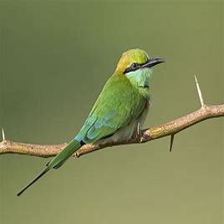

In [102]:
from PIL import Image

img = Image.open(r"D:\test_images\Asian-Green-Bee-Eater.jpeg").resize((224,224))
img

In [103]:
img = tf.keras.preprocessing.image.img_to_array(img)

img = np.expand_dims(img,axis=0)

class_name[np.argmax(bird_model.predict(img))]

1/1 [==============================] - 0s 16ms/step


'Asian-Green-Bee-Eater'

In [87]:
y_true = []

y_pred = []

for image,label in test_ds:
    for i in range(32):
        img = np.expand_dims(image[i].numpy(),axis=0)
        y_pred.append(np.argmax(bird_model.predict(img)))
        y_true.append(label[i].numpy())

1/1 [==============================] - 0s 35ms/step


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 6 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [94]:
from sklearn.metrics import confusion_matrix,classification_report

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       165
           1       0.82      0.86      0.84       162
           2       0.98      0.99      0.98       155
           3       0.93      0.97      0.95       143
           4       0.91      0.90      0.91       151
           5       0.85      0.84      0.84       152
           6       0.86      0.81      0.84       135
           7       0.89      0.90      0.89       156
           8       0.83      0.95      0.89       164
           9       0.96      0.86      0.91       145
          10       0.93      0.95      0.94       153
          11       0.87      0.88      0.87       146
          12       0.85      0.84      0.84       134
          13       0.95      0.90      0.93       151
          14       0.94      0.93      0.93       155
          15       0.90      0.84      0.87       153
          16       0.91      0.95      0.93       143
          17       0.89    